# Medical Image Classification with ResNet, ViT, and GAN-based Data Augmentation  

This notebook explores the application of deep learning models for medical image classification.  
We focus on chest X-ray images to distinguish between **NORMAL** and **PNEUMONIA** cases.  

The workflow includes:  
- Training and evaluating **ResNet** and **Vision Transformer (ViT)** models, both with and without fine-tuning.  
- Generating synthetic chest X-ray images using **GANs (DCGAN and cGAN)**.  
- Augmenting the dataset with GAN-generated images and assessing their impact on classification performance.  

The main objective is to analyze whether GAN-based data augmentation improves the robustness and accuracy of medical image classifiers.  


# Check GPU Availability

In [ ]:
# Check if GPU is available
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", device)


✅ Using device: cuda


In [ ]:
# Install some useful libraries
!pip install timm transformers datasets torchvision matplotlib seaborn --quiet

# Import from major libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import timm   # To charge ViT
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Downloading and organizing the dataset

In [ ]:
# Create Kaggle folder
!mkdir -p ~/.kaggle

# Upload the kaggle.json file from your PC
from google.colab import files
files.upload()

# Move the kaggle.json file to the correct location
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the Chest X-Ray Pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the dataset
!unzip -q chest-xray-pneumonia.zip -d chest_xray



Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 96% 2.21G/2.29G [00:08<00:00, 478MB/s]
100% 2.29G/2.29G [00:08<00:00, 303MB/s]


##  Display Sample Images from the Dataset

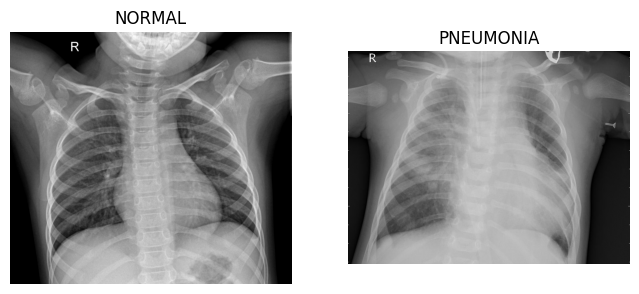

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Example images
base_dir = "chest_xray/chest_xray/train"
classes = ["NORMAL", "PNEUMONIA"]

plt.figure(figsize=(8,4))
for i, cls in enumerate(classes):
    path = os.path.join(base_dir, cls)
    img_path = random.choice(os.listdir(path))
    img = Image.open(os.path.join(path, img_path))
    plt.subplot(1,2,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(cls)
    plt.axis("off")
plt.show()


# Preprocess and Load the Chest X-Ray Dataset

In [ ]:
# Preprocessing: resize (224x224 since ResNet/ViT expect this), convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # simple normalization [-1,1]
])

# Load datasets
train_dataset = datasets.ImageFolder("chest_xray/chest_xray/train", transform=transform)
val_dataset   = datasets.ImageFolder("chest_xray/chest_xray/val", transform=transform)
test_dataset  = datasets.ImageFolder("chest_xray/chest_xray/test", transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset sizes
print("Number of images:")
print("Train :", len(train_dataset))
print("Val   :", len(val_dataset))
print("Test  :", len(test_dataset))
print("Classes :", train_dataset.classes)


Number of images:
Train : 5216
Val   : 16
Test  : 624
Classes : ['NORMAL', 'PNEUMONIA']


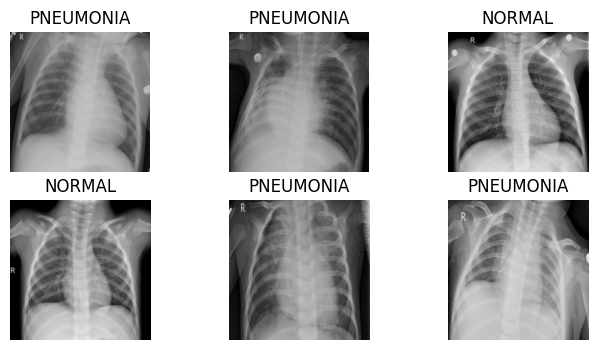

In [ ]:
# Example batch from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    img = images[i].permute(1,2,0).numpy()
    img = (img * 0.5 + 0.5)  # de-normalization for display
    plt.imshow(img)
    plt.title(train_dataset.classes[labels[i]])
    plt.axis("off")
plt.show()


# Fine-tuning ResNet50

## Evaluate Pre-trained ResNet50 Without Fine-tuning

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load pre-trained ResNet50
resnet_base = models.resnet50(pretrained=True)

# Freeze all parameters
for param in resnet_base.parameters():
    param.requires_grad = False

# Adapt the final layer for 2 classes
num_ftrs = resnet_base.fc.in_features
resnet_base.fc = nn.Linear(num_ftrs, 2)

resnet_base = resnet_base.to(device)

# Evaluation without training (ImageNet weights + random new layer)
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Direct evaluation
y_true_base, y_pred_base = evaluate_model(resnet_base, test_loader)
print("📊 Evaluation ResNet50 without fine-tuning (only feature extractor):")
print(classification_report(y_true_base, y_pred_base, target_names=train_dataset.classes))

cm = confusion_matrix(y_true_base, y_pred_base)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix - ResNet without fine-tuning")
plt.show()


## Fine-tune ResNet50 with Training and Validation

In [ ]:
# Load pre-trained ResNet50
resnet_ft = models.resnet50(pretrained=True)

# Adapt the final layer
num_ftrs = resnet_ft.fc.in_features
resnet_ft.fc = nn.Linear(num_ftrs, 2)

resnet_ft = resnet_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_ft.parameters(), lr=1e-4)

# Training function with best model saving
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, model_name="best_resnet.pth"):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{epochs}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_name)
            print(f"🌟 New best model saved with Val Acc = {best_acc:.2f}%")

    model.load_state_dict(torch.load(model_name))
    print(f"\n✅ Training complete. Best Val Acc = {best_acc:.2f}%")
    return model

# Training
resnet_ft = train_model(resnet_ft, train_loader, val_loader, criterion, optimizer, epochs=5)


## Evaluate Fine-tuned ResNet50

In [ ]:
y_true_ft, y_pred_ft = evaluate_model(resnet_ft, test_loader)

print("📊 Evaluation ResNet50 with full fine-tuning:")
print(classification_report(y_true_ft, y_pred_ft, target_names=train_dataset.classes))

cm = confusion_matrix(y_true_ft, y_pred_ft)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix - ResNet with fine-tuning")
plt.show()


# Evaluate Pre-trained ViT Without Fine-tuning

This code loads a pre-trained **Vision Transformer (ViT)**, freezes its parameters to act as a feature extractor, and replaces the classification head with a binary classifier. The model is then evaluated directly on the test set (without training), showing the classification report and confusion matrix.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

📊 Evaluation ViT without fine-tuning (feature extractor):
              precision    recall  f1-score   support

      NORMAL       0.43      0.19      0.26       234
   PNEUMONIA       0.64      0.85      0.73       390

    accuracy                           0.60       624
   macro avg       0.53      0.52      0.49       624
weighted avg       0.56      0.60      0.55       624



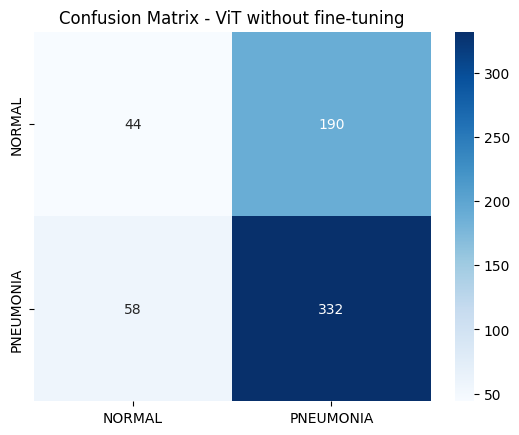

In [ ]:
import timm

# Load pre-trained ViT
vit_base = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)

# Freeze all parameters (feature extractor)
for param in vit_base.parameters():
    param.requires_grad = False

# Adapt the classification head
vit_base.head = nn.Linear(vit_base.head.in_features, 2)

vit_base = vit_base.to(device)

# Direct evaluation without training
y_true_vit_base, y_pred_vit_base = evaluate_model(vit_base, test_loader)

print("📊 Evaluation ViT without fine-tuning (feature extractor):")
print(classification_report(y_true_vit_base, y_pred_vit_base, target_names=train_dataset.classes))

cm = confusion_matrix(y_true_vit_base, y_pred_vit_base)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix - ViT without fine-tuning")
plt.show()


## Fine-tune Vision Transformer (ViT)

In [ ]:
# Load pre-trained ViT with all layers trainable
vit_ft = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)
vit_ft = vit_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_ft.parameters(), lr=1e-4)

# Training
vit_ft = train_model(vit_ft, train_loader, val_loader, criterion, optimizer, epochs=5, model_name="best_vit.pth")


Epoch [1/5] Train Acc: 88.34% | Val Acc: 50.00%
🌟 New best model saved with Val Acc = 50.00%
Epoch [2/5] Train Acc: 96.36% | Val Acc: 56.25%
🌟 New best model saved with Val Acc = 56.25%
Epoch [3/5] Train Acc: 98.10% | Val Acc: 100.00%
🌟 New best model saved with Val Acc = 100.00%
Epoch [4/5] Train Acc: 98.41% | Val Acc: 93.75%
Epoch [5/5] Train Acc: 98.85% | Val Acc: 87.50%

✅ Training complete. Best Val Acc = 100.00%


## Evaluate fine-tuned ViT

📊 Evaluation ViT with fine-tuning:
              precision    recall  f1-score   support

      NORMAL       0.88      0.79      0.84       234
   PNEUMONIA       0.88      0.94      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



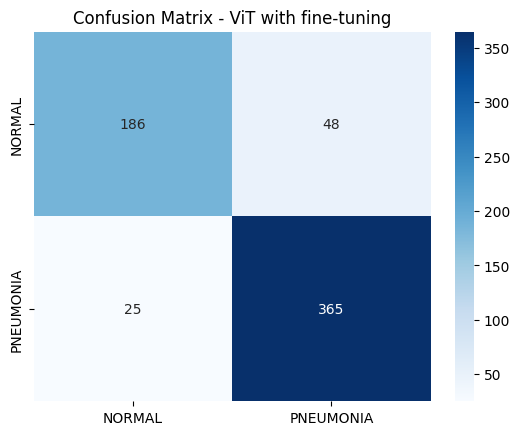

In [ ]:
# Evaluate fine-tuned ViT
y_true_vit_ft, y_pred_vit_ft = evaluate_model(vit_ft, test_loader)

print("📊 Evaluation ViT with fine-tuning:")
print(classification_report(y_true_vit_ft, y_pred_vit_ft, target_names=train_dataset.classes))

cm = confusion_matrix(y_true_vit_ft, y_pred_vit_ft)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix - ViT with fine-tuning")
plt.show()


#Comparison of ResNet50 vs ViT (with/without fine-tuning)

📊 ResNet50 (No FT) - Accuracy: 61.54% | Recall: 61.54% | F1: 56.52%
📊 ResNet50 (FT) - Accuracy: 75.32% | Recall: 75.32% | F1: 71.49%
📊 ViT (No FT) - Accuracy: 60.26% | Recall: 60.26% | F1: 55.33%
📊 ViT (FT) - Accuracy: 88.30% | Recall: 88.30% | F1: 88.17%


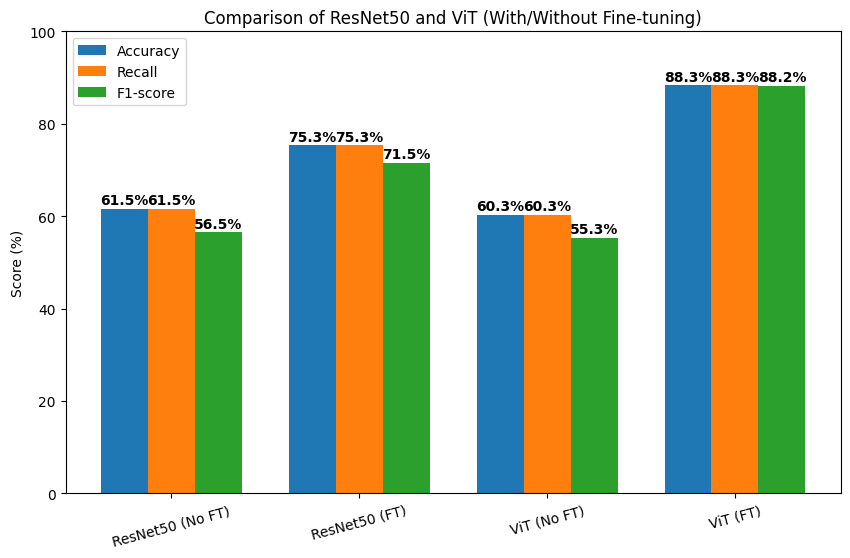

In [ ]:
from sklearn.metrics import classification_report

# ⚡️ Comparison of ResNet50 vs ViT (with/without fine-tuning)

models_dict = {
    "ResNet50 (No FT)": resnet_base,
    "ResNet50 (FT)": resnet_ft,
    "ViT (No FT)": vit_base,
    "ViT (FT)": vit_ft
}

metrics = {"Accuracy": [], "Recall": [], "F1-score": []}
model_names = []

for name, model in models_dict.items():
    y_true, y_pred = evaluate_model(model, test_loader)

    # Classification report as dictionary
    report = classification_report(y_true, y_pred, target_names=train_dataset.classes, output_dict=True)

    acc = (y_true == y_pred).mean() * 100
    recall = report["weighted avg"]["recall"] * 100
    f1 = report["weighted avg"]["f1-score"] * 100

    metrics["Accuracy"].append(acc)
    metrics["Recall"].append(recall)
    metrics["F1-score"].append(f1)
    model_names.append(name)

    print(f"📊 {name} - Accuracy: {acc:.2f}% | Recall: {recall:.2f}% | F1: {f1:.2f}%")

# --- Plot grouped bar chart ---
x = np.arange(len(model_names))  # model indices
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, metrics["Accuracy"], width, label="Accuracy")
plt.bar(x, metrics["Recall"], width, label="Recall")
plt.bar(x + width, metrics["F1-score"], width, label="F1-score")

plt.ylabel("Score (%)")
plt.title("Comparison of ResNet50 and ViT (With/Without Fine-tuning)")
plt.xticks(x, model_names, rotation=15)
plt.ylim(0, 100)
plt.legend()

# Annotate bars
for metric_name, values, shift in zip(metrics.keys(), metrics.values(), [-width, 0, width]):
    for i, v in enumerate(values):
        plt.text(i + shift, v + 1, f"{v:.1f}%", ha="center", fontweight="bold")

plt.show()


#Define a simple DGAN to generate medical images

In [ ]:
import torch
import torch.nn as nn

# --- Generator ---
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(3, 224, 224)):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()  # values in [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img


# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, img_shape=(3, 224, 224)):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


##Training loop for DGAN

In [ ]:
import torch.optim as optim

# Hyperparameters
latent_dim = 100
epochs = 50
lr = 0.0002
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize models
generator = Generator(latent_dim=latent_dim, img_shape=(3, 224, 224)).to(device)
discriminator = Discriminator(img_shape=(3, 224, 224)).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        real_imgs = imgs.to(device)

        batch_size = real_imgs.size(0)

        # Labels
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch+1}/{epochs}] D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")


[Epoch 1/50] D loss: 0.4038 | G loss: 0.6738
[Epoch 2/50] D loss: 0.3740 | G loss: 0.8042
[Epoch 3/50] D loss: 0.5833 | G loss: 0.4385
[Epoch 4/50] D loss: 0.5131 | G loss: 0.7563
[Epoch 5/50] D loss: 0.5478 | G loss: 0.5321
[Epoch 6/50] D loss: 0.4177 | G loss: 0.8132
[Epoch 7/50] D loss: 0.3898 | G loss: 0.9756
[Epoch 8/50] D loss: 0.3471 | G loss: 1.0568
[Epoch 9/50] D loss: 0.5713 | G loss: 0.5945
[Epoch 10/50] D loss: 0.6072 | G loss: 0.5705
[Epoch 11/50] D loss: 0.4612 | G loss: 1.0085
[Epoch 12/50] D loss: 0.4799 | G loss: 0.8209
[Epoch 13/50] D loss: 0.3404 | G loss: 0.9560
[Epoch 14/50] D loss: 0.4033 | G loss: 1.0518
[Epoch 15/50] D loss: 0.5006 | G loss: 0.6397
[Epoch 16/50] D loss: 0.7738 | G loss: 0.9278
[Epoch 17/50] D loss: 0.4418 | G loss: 1.4340
[Epoch 18/50] D loss: 0.8132 | G loss: 1.0464
[Epoch 19/50] D loss: 0.5085 | G loss: 1.1307
[Epoch 20/50] D loss: 0.5609 | G loss: 0.6760
[Epoch 21/50] D loss: 0.4321 | G loss: 0.8616
[Epoch 22/50] D loss: 0.4090 | G loss: 1.01

In [ ]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
print("✅ Models saved successfully!")

✅ Models saved successfully!


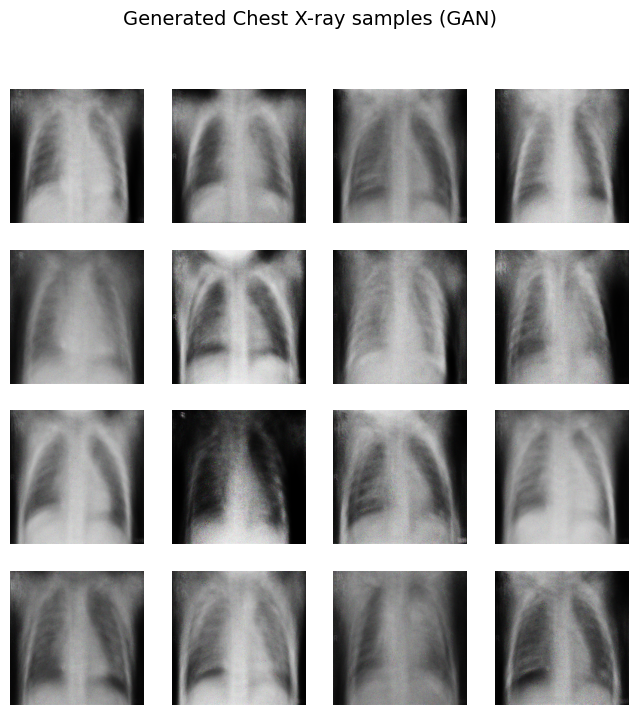

In [ ]:
import matplotlib.pyplot as plt

generator.eval()

# Generate a batch of 16 fake images
z = torch.randn(16, latent_dim, device=device)
gen_imgs = generator(z).detach().cpu()

# Rescale from [-1,1] → [0,1] for display
gen_imgs = (gen_imgs + 1) / 2

# Plot
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    img = gen_imgs[i].permute(1,2,0).numpy()
    ax.imshow(img)
    ax.axis("off")
plt.suptitle("Generated Chest X-ray samples (GAN)", fontsize=14)
plt.show()


##Generate images with GAN and pseudo-classify with ResNet50

In [ ]:
import os
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# --------------------------
# Step 1: Load generator (already trained and saved)
# --------------------------
generator = Generator(latent_dim=latent_dim, img_shape=(3, 224, 224)).to(device)
generator.load_state_dict(torch.load("generator.pth", map_location=device))
generator.eval()
print("✅ Generator loaded successfully!")

# --------------------------
# Step 2: Generate fake images
# --------------------------
os.makedirs("gan_generated_resnet", exist_ok=True)

num_fake = 500  # number of fake images to generate
fake_img_paths = []
fake_labels = []

with torch.no_grad():
    for i in range(num_fake):
        z = torch.randn(1, latent_dim, device=device)
        gen_img = generator(z)
        gen_img = (gen_img + 1) / 2  # rescale to [0,1]

        # Save image to disk
        save_path = f"gan_generated_resnet/fake_{i}.png"
        save_image(gen_img, save_path)

        # Resize + normalize to same format as ResNet training
        img = Image.open(save_path).convert("RGB")
        img_t = transform(img).unsqueeze(0).to(device)  # apply same transform

        # Pseudo-label prediction with ResNet50 fine-tuned
        pred = resnet_ft(img_t).argmax(1).item()

        fake_img_paths.append(save_path)
        fake_labels.append(pred)

print(f"✅ Generated and pseudo-labeled {len(fake_img_paths)} fake images")


✅ Generator loaded successfully!
✅ Generated and pseudo-labeled 500 fake images


##Build a mixed DataLoader (real + pseudo-classified fake)

In [ ]:
class FakeDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Create dataset for fake images
fake_dataset = FakeDataset(fake_img_paths, fake_labels, transform=transform)

# Combine with real dataset (train_dataset)
from torch.utils.data import ConcatDataset

augmented_dataset = ConcatDataset([train_dataset, fake_dataset])

# New DataLoader (mix of real + fake)
augmented_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)

print("✅ Augmented DataLoader ready:")
print("  - Real samples :", len(train_dataset))
print("  - Fake samples :", len(fake_dataset))
print("  - Total samples:", len(augmented_dataset))


✅ Augmented DataLoader ready:
  - Real samples : 5216
  - Fake samples : 500
  - Total samples: 5716


##Fine-tuning ResNet50 with augmented dataset (real + fake)

In [ ]:
# Reload a fresh ResNet50 (to compare fairly with baseline)
resnet_aug = models.resnet50(pretrained=True)

# Adapt the final layer for binary classification
num_ftrs = resnet_aug.fc.in_features
resnet_aug.fc = nn.Linear(num_ftrs, 2)
resnet_aug = resnet_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_aug.parameters(), lr=1e-4)

# Training function (same as before)
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, model_name="best_resnet_aug.pth"):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{epochs}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_name)
            print(f"🌟 New best model saved with Val Acc = {best_acc:.2f}%")

    model.load_state_dict(torch.load(model_name))
    print(f"\n✅ Training complete. Best Val Acc = {best_acc:.2f}%")
    return model

# Train ResNet50 with augmented data (real + fake)
resnet_aug = train_model(resnet_aug, augmented_loader, val_loader, criterion, optimizer, epochs=5, model_name="best_resnet_aug.pth")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] Train Acc: 97.48% | Val Acc: 100.00%
🌟 New best model saved with Val Acc = 100.00%
Epoch [2/5] Train Acc: 99.09% | Val Acc: 93.75%
Epoch [3/5] Train Acc: 99.27% | Val Acc: 93.75%
Epoch [4/5] Train Acc: 99.56% | Val Acc: 93.75%
Epoch [5/5] Train Acc: 99.77% | Val Acc: 100.00%

✅ Training complete. Best Val Acc = 100.00%


##Evaluation of ResNet50 trained with augmented data (real + fake)

📊 Evaluation ResNet50 with GAN-augmented training data:
              precision    recall  f1-score   support

      NORMAL       1.00      0.24      0.38       234
   PNEUMONIA       0.69      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.84      0.62      0.60       624
weighted avg       0.80      0.71      0.65       624



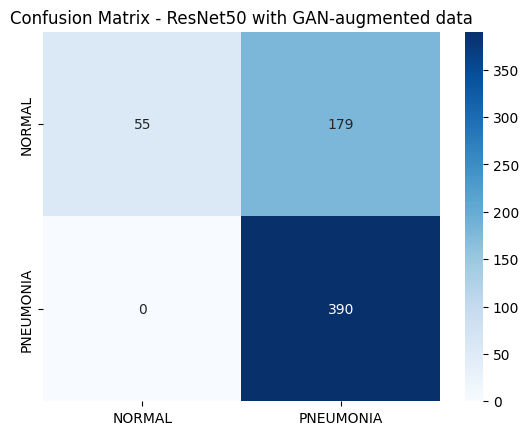

In [ ]:
# Evaluate ResNet50 trained with augmented data on test set
y_true_aug, y_pred_aug = evaluate_model(resnet_aug, test_loader)

print("📊 Evaluation ResNet50 with GAN-augmented training data:")
print(classification_report(y_true_aug, y_pred_aug, target_names=train_dataset.classes))

cm = confusion_matrix(y_true_aug, y_pred_aug)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix - ResNet50 with GAN-augmented data")
plt.show()


##Generate images with GAN and pseudo-classify with ViT fine-tuned

In [ ]:
import os
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# --------------------------
# Step 1: Reload generator (already trained and saved)
# --------------------------
generator = Generator(latent_dim=latent_dim, img_shape=(3, 224, 224)).to(device)
generator.load_state_dict(torch.load("generator.pth", map_location=device))
generator.eval()
print("✅ Generator loaded successfully!")

# --------------------------
# Step 2: Generate fake images
# --------------------------
os.makedirs("gan_generated_vit", exist_ok=True)

num_fake_vit = 500  # number of fake images for ViT
fake_img_paths_vit = []
fake_labels_vit = []

with torch.no_grad():
    for i in range(num_fake_vit):
        z = torch.randn(1, latent_dim, device=device)
        gen_img = generator(z)
        gen_img = (gen_img + 1) / 2  # rescale to [0,1]

        # Save image to disk
        save_path = f"gan_generated_vit/fake_{i}.png"
        save_image(gen_img, save_path)

        # Resize + normalize with the same transform as ViT training
        img = Image.open(save_path).convert("RGB")
        img_t = transform(img).unsqueeze(0).to(device)

        # Pseudo-label prediction with fine-tuned ViT
        pred = vit_ft(img_t).argmax(1).item()

        fake_img_paths_vit.append(save_path)
        fake_labels_vit.append(pred)

print(f"✅ Generated and pseudo-labeled {len(fake_img_paths_vit)} fake images for ViT")


✅ Generator loaded successfully!
✅ Generated and pseudo-labeled 500 fake images for ViT


##DataLoader + ViT Fine-tuning with augmented data

In [ ]:
from torch.utils.data import ConcatDataset


class FakeDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Fake dataset for ViT
fake_dataset_vit = FakeDataset(fake_img_paths_vit, fake_labels_vit, transform=transform)

# Combine with real dataset
augmented_dataset_vit = ConcatDataset([train_dataset, fake_dataset_vit])

# New DataLoader
augmented_loader_vit = DataLoader(augmented_dataset_vit, batch_size=32, shuffle=True)

print("✅ Augmented DataLoader for ViT ready:")
print("  - Real samples :", len(train_dataset))
print("  - Fake samples :", len(fake_dataset_vit))
print("  - Total samples:", len(augmented_dataset_vit))

# --------------------------
# Step 2: Reload a fresh ViT (for fair comparison)
# --------------------------
vit_aug = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)
vit_aug = vit_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_aug.parameters(), lr=1e-4)

# --------------------------
# Step 3: Fine-tuning with augmented data
# --------------------------
vit_aug = train_model(vit_aug, augmented_loader_vit, val_loader,
                      criterion, optimizer, epochs=5, model_name="best_vit_aug.pth")


✅ Augmented DataLoader for ViT ready:
  - Real samples : 5216
  - Fake samples : 500
  - Total samples: 5716
Epoch [1/5] Train Acc: 88.59% | Val Acc: 75.00%
🌟 New best model saved with Val Acc = 75.00%
Epoch [2/5] Train Acc: 97.29% | Val Acc: 75.00%
Epoch [3/5] Train Acc: 97.95% | Val Acc: 87.50%
🌟 New best model saved with Val Acc = 87.50%
Epoch [4/5] Train Acc: 98.72% | Val Acc: 81.25%
Epoch [5/5] Train Acc: 99.25% | Val Acc: 87.50%

✅ Training complete. Best Val Acc = 87.50%


##Evaluate ViT trained with augmented data on test set

📊 Evaluation ViT with GAN-augmented training data:
              precision    recall  f1-score   support

      NORMAL       0.92      0.68      0.79       234
   PNEUMONIA       0.84      0.97      0.90       390

    accuracy                           0.86       624
   macro avg       0.88      0.83      0.84       624
weighted avg       0.87      0.86      0.86       624



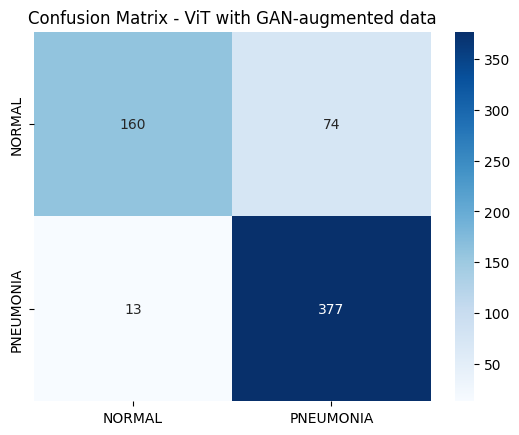

In [ ]:

y_true_vit_aug, y_pred_vit_aug = evaluate_model(vit_aug, test_loader)

print("📊 Evaluation ViT with GAN-augmented training data:")
print(classification_report(y_true_vit_aug, y_pred_vit_aug, target_names=train_dataset.classes))

cm = confusion_matrix(y_true_vit_aug, y_pred_vit_aug)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix - ViT with GAN-augmented data")
plt.show()


#Conditional Generator cGAN

In [ ]:
import torch
import torch.nn as nn

# --- Conditional Generator (CNN-based) ---
class Generator_cGAN(nn.Module):
    def __init__(self, latent_dim, n_classes=2, img_size=224, channels=3):
        super(Generator_cGAN, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.init_size = img_size // 32  # 224/32 = 7
        self.l1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),  # 7 -> 14
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # 14 -> 28
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # 28 -> 56
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),    # 56 -> 112
            nn.ReLU(True),
            nn.ConvTranspose2d(16, channels, 4, stride=2, padding=1),  # 112 -> 224
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img



# --- Conditional Discriminator (CNN-based) ---
class Discriminator_cGAN(nn.Module):
    def __init__(self, n_classes=2, img_size=224, channels=3):
        super(Discriminator_cGAN, self).__init__()
        # Embedding en 1 seule dimension pour produire un canal unique
        self.label_emb = nn.Embedding(n_classes, 1)

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        # Attention: +1 channel (3 channel image + 1 label channel)
        self.model = nn.Sequential(
            *discriminator_block(channels + 1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_size // 16
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embedding the label into a single channel
        label_map = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # [batch,1,1,1]
        label_map = label_map.expand(labels.size(0), 1, img.size(2), img.size(3))  # [batch,1,H,W]

        # Concatenation with image (3 channels + 1 channel)
        d_in = torch.cat((img, label_map), 1)
        out = self.model(d_in)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

##Training + Intermediate Visualization

In [ ]:
import torch.optim as optim
import torch

# Hyperparameters
latent_dim = 100
epochs = 50
lr = 0.0002
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize models
generator = Generator_cGAN(latent_dim=latent_dim, n_classes=2, img_size=224).to(device)
discriminator = Discriminator_cGAN(n_classes=2, img_size=224, channels=3).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Track best losses
best_g_loss = float("inf")
best_d_loss = float("inf")

for epoch in range(epochs):
    g_epoch_loss, d_epoch_loss = 0.0, 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        # Ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z, labels)  # conditioned on labels
        g_loss = adversarial_loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        g_epoch_loss += g_loss.item()
        d_epoch_loss += d_loss.item()

    g_epoch_loss /= len(train_loader)
    d_epoch_loss /= len(train_loader)

    print(f"[Epoch {epoch+1}/{epochs}] D loss: {d_epoch_loss:.4f} | G loss: {g_epoch_loss:.4f}")

    # Save best models
    if g_epoch_loss < best_g_loss:
        best_g_loss = g_epoch_loss
        torch.save(generator.state_dict(), "best_cgan_generator.pth")
        print(f"🌟 New best Generator saved (G loss: {best_g_loss:.4f})")

    if d_epoch_loss < best_d_loss:
        best_d_loss = d_epoch_loss
        torch.save(discriminator.state_dict(), "best_cgan_discriminator.pth")
        print(f"🌟 New best Discriminator saved (D loss: {best_d_loss:.4f})")

print("✅ Training finished. Best models saved.")


[Epoch 1/50] D loss: 0.2069 | G loss: 2.2073
🌟 New best Generator saved (G loss: 2.2073)
🌟 New best Discriminator saved (D loss: 0.2069)
[Epoch 2/50] D loss: 0.1787 | G loss: 2.7466
🌟 New best Discriminator saved (D loss: 0.1787)
[Epoch 3/50] D loss: 0.4967 | G loss: 1.8573
🌟 New best Generator saved (G loss: 1.8573)
[Epoch 4/50] D loss: 0.5092 | G loss: 1.2237
🌟 New best Generator saved (G loss: 1.2237)
[Epoch 5/50] D loss: 0.5259 | G loss: 1.1219
🌟 New best Generator saved (G loss: 1.1219)
[Epoch 6/50] D loss: 0.5761 | G loss: 0.9981
🌟 New best Generator saved (G loss: 0.9981)
[Epoch 7/50] D loss: 0.5790 | G loss: 0.9751
🌟 New best Generator saved (G loss: 0.9751)
[Epoch 8/50] D loss: 0.5944 | G loss: 0.9114
🌟 New best Generator saved (G loss: 0.9114)
[Epoch 9/50] D loss: 0.5989 | G loss: 0.8974
🌟 New best Generator saved (G loss: 0.8974)
[Epoch 10/50] D loss: 0.6079 | G loss: 0.9020
[Epoch 11/50] D loss: 0.6085 | G loss: 0.8629
🌟 New best Generator saved (G loss: 0.8629)
[Epoch 12/5

##Reload & Test the Saved Generator

✅ Best Generator reloaded successfully!


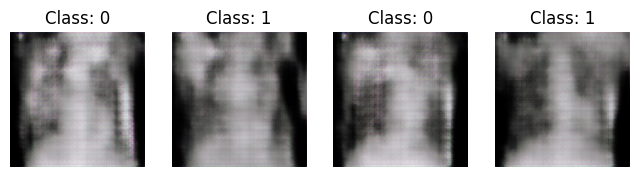

In [ ]:
import matplotlib.pyplot as plt

# Reload the best Generator
generator = Generator_cGAN(latent_dim=100, n_classes=2, img_size=224).to(device)
generator.load_state_dict(torch.load("best_cgan_generator.pth", map_location=device))
generator.eval()
print("✅ Best Generator reloaded successfully!")

# Generate samples
n_samples = 4
z = torch.randn(n_samples, latent_dim, device=device)

# Generate both NORMAL (0) and PNEUMONIA (1) examples
labels = torch.tensor([0, 1, 0, 1], device=device)  # Example labels
with torch.no_grad():
    gen_imgs = generator(z, labels).cpu()

# Rescale from [-1,1] → [0,1] for visualization
gen_imgs = (gen_imgs + 1) / 2

# Plot results
plt.figure(figsize=(8,4))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(gen_imgs[i].permute(1,2,0))
    plt.title(f"Class: {labels[i].item()}")
    plt.axis("off")
plt.show()


##Reload & Test the Saved Discriminator

In [ ]:
# Reload the best Discriminator
discriminator = Discriminator_cGAN(n_classes=2, img_size=224, channels=3).to(device)
discriminator.load_state_dict(torch.load("best_cgan_discriminator.pth", map_location=device))
discriminator.eval()
print("✅ Best Discriminator reloaded successfully!")

# Get a small batch of real images
real_imgs, real_labels = next(iter(train_loader))
real_imgs, real_labels = real_imgs.to(device), real_labels.to(device)

# Generate a batch of fake images
z = torch.randn(real_imgs.size(0), latent_dim, device=device)
fake_imgs = generator(z, real_labels).to(device)  # conditioned on same labels

# Evaluate Discriminator
with torch.no_grad():
    real_scores = discriminator(real_imgs, real_labels)
    fake_scores = discriminator(fake_imgs, real_labels)

print("📊 Discriminator test:")
print(f"Real scores (mean): {real_scores.mean().item():.4f}")
print(f"Fake scores (mean): {fake_scores.mean().item():.4f}")


✅ Best Discriminator reloaded successfully!
📊 Discriminator test:
Real scores (mean): 0.3828
Fake scores (mean): 0.4077


##Generation of an artificial dataset

In [ ]:
import os
from torchvision.utils import save_image

# Parameters
n_per_class = 500  # number of synthetic images per class
latent_dim = 100
classes = ["NORMAL", "PNEUMONIA"]
output_dir = "synthetic/train"

os.makedirs(output_dir, exist_ok=True)

generator.eval()
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    for i in range(n_per_class):
        z = torch.randn(1, latent_dim, device=device)
        labels = torch.tensor([class_idx], device=device)
        with torch.no_grad():
            gen_img = generator(z, labels).cpu()

        # Rescale [-1,1] → [0,1]
        gen_img = (gen_img + 1) / 2
        save_image(gen_img, os.path.join(class_dir, f"{class_name}_{i}.png"))

print("✅ Synthetic dataset generated successfully!")


✅ Synthetic dataset generated successfully!


## ResNet50 training on mixed data (real + synthetic)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, model_name="best_model.pth"):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # 🔹 Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{epochs}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_name)
            print(f"🌟 New best model saved with Val Acc = {best_acc:.2f}%")


    model.load_state_dict(torch.load(model_name))
    print(f"\n✅ Training finished. Best Val Acc = {best_acc:.2f}%")
    return model


In [ ]:
from torch.utils.data import ConcatDataset

# Load real dataset
real_dataset = datasets.ImageFolder("chest_xray/chest_xray/train", transform=transform)

# Load synthetic dataset
synthetic_dataset = datasets.ImageFolder("synthetic/train", transform=transform)

# Merge real and synthetic datasets
mixed_dataset = ConcatDataset([real_dataset, synthetic_dataset])
mixed_loader = DataLoader(mixed_dataset, batch_size=32, shuffle=True)

print("Mixed dataset loaded:")
print("Real images:", len(real_dataset))
print("Synthetic images:", len(synthetic_dataset))
print("Total mixed:", len(mixed_dataset))

# Load pretrained ResNet50
resnet_mixed = models.resnet50(pretrained=True)
num_ftrs = resnet_mixed.fc.in_features
resnet_mixed.fc = nn.Linear(num_ftrs, 2)
resnet_mixed = resnet_mixed.to(device)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_mixed.parameters(), lr=1e-4)

# Train on mixed data
resnet_mixed = train_model(
    resnet_mixed,
    mixed_loader,   # training on real + synthetic
    val_loader,     # validation on real images only
    criterion,
    optimizer,
    epochs=5,
    model_name="resnet_mixed.pth"
)


✅ Mixed dataset loaded:
Real images: 5216
Synthetic images: 1000
Total mixed: 6216
Epoch [1/5] Train Acc: 96.14% | Val Acc: 100.00%
🌟 New best model saved with Val Acc = 100.00%
Epoch [2/5] Train Acc: 98.76% | Val Acc: 93.75%
Epoch [3/5] Train Acc: 99.05% | Val Acc: 68.75%
Epoch [4/5] Train Acc: 99.21% | Val Acc: 100.00%
Epoch [5/5] Train Acc: 99.40% | Val Acc: 93.75%

✅ Training finished. Best Val Acc = 100.00%



📊 ResNet50 (Mixed Data) - Test Accuracy: 80.45%
              precision    recall  f1-score   support

      NORMAL       0.97      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.74      0.76       624
weighted avg       0.84      0.80      0.79       624



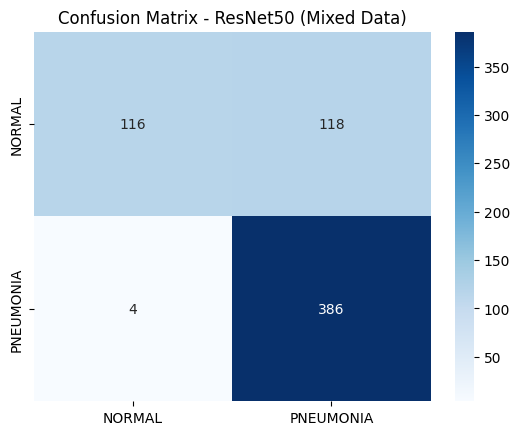

np.float64(80.44871794871796)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean() * 100
    print(f"\n📊 {model_name} - Test Accuracy: {acc:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    return acc


evaluate_model(resnet_ft, test_loader, model_name="ResNet50 (Real Data)")

evaluate_model(resnet_mixed, test_loader, model_name="ResNet50 (Mixed Data)")


##Fine-tuning ViT on mixed data

In [ ]:
# Load pretrained ViT
vit_mixed = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)
vit_mixed = vit_mixed.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_mixed.parameters(), lr=1e-4)

# Train on mixed dataset (real + synthetic)
vit_mixed = train_model(
    vit_mixed,
    mixed_loader,   # training on real + synthetic images
    val_loader,     # validation on real images only
    criterion,
    optimizer,
    epochs=5,
    model_name="vit_mixed.pth"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch [1/5] Train Acc: 87.48% | Val Acc: 68.75%
🌟 New best model saved with Val Acc = 68.75%
Epoch [2/5] Train Acc: 95.58% | Val Acc: 81.25%
🌟 New best model saved with Val Acc = 81.25%
Epoch [3/5] Train Acc: 96.90% | Val Acc: 87.50%
🌟 New best model saved with Val Acc = 87.50%
Epoch [4/5] Train Acc: 98.23% | Val Acc: 62.50%
Epoch [5/5] Train Acc: 98.84% | Val Acc: 62.50%

✅ Training finished. Best Val Acc = 87.50%


Évaluation finale de ViT (réel vs mixte)


📊 ViT (Mixed Data) - Test Accuracy: 85.74%
              precision    recall  f1-score   support

      NORMAL       0.91      0.69      0.78       234
   PNEUMONIA       0.84      0.96      0.89       390

    accuracy                           0.86       624
   macro avg       0.87      0.82      0.84       624
weighted avg       0.86      0.86      0.85       624



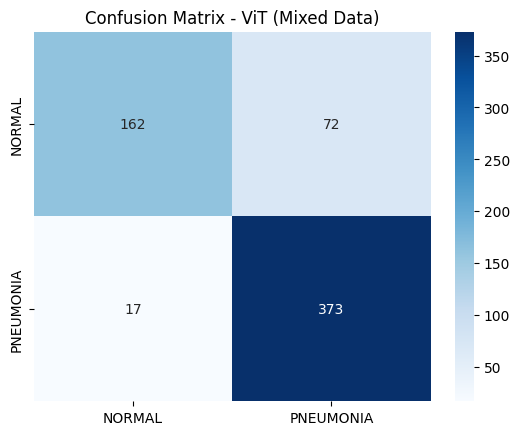

np.float64(85.73717948717949)

In [ ]:
# Evaluate fine-tuned ViT on mixed data (real + synthetic)
evaluate_model(vit_mixed, test_loader, model_name="ViT (Mixed Data)")

#  Comparative Analysis: ResNet50 vs ViT (With/Without Fine-tuning, GAN, cGAN)

##  ResNet50
- **Without fine-tuning**: Accuracy ≈ **62%**. Strong bias toward *PNEUMONIA* (recall 0.87) but poor detection of *NORMAL* (recall 0.20).  
- **With fine-tuning**: Accuracy ≈ **75%**. Clear improvement, but still unbalanced (recall NORMAL = 0.35, PNEUMONIA = 0.99).  
- **With GAN-augmented data**: Accuracy ≈ **71%**. No significant improvement; synthetic data even introduces noise.  
- **With cGAN-augmented data**: Accuracy ≈ **80%**. Best ResNet50 performance, more balanced results (NORMAL recall = 0.50, PNEUMONIA = 0.99).  

✅ *Conclusion*: ResNet50 benefits significantly from **cGAN augmentation**, showing that conditional synthetic data helps compensate for class imbalance.  

---

##  Vision Transformer (ViT)
- **Without fine-tuning**: Accuracy ≈ **60%**, weak performance.  
- **With fine-tuning**: Accuracy ≈ **88%**, strong balance between precision and recall.  
- **With GAN-augmented data**: Accuracy ≈ **86%**, slightly lower than fine-tuning only.  
- **With cGAN-augmented data**: Accuracy ≈ **86%**, similar to fine-tuning, with balanced results (NORMAL recall ≈ 0.69, PNEUMONIA ≈ 0.96).  

 *Conclusion*: ViT achieves excellent performance with fine-tuning alone. GAN/cGAN augmentation does not bring extra gain, confirming the **robustness of transformers** on medical data.  

---

##  Why GAN-based Data Augmentation Did Not Improve Performance?

1. **Quality of synthetic images**:  
   GAN/cGAN models may generate **blurry or unrealistic images**, which can introduce noise instead of meaningful variability.  
2. **Dataset size**:  
   If the base dataset is already sufficiently large, adding synthetic data may not significantly help — especially for ViT, which generalizes well with enough real data.  
3. **Mode collapse** (GAN limitation):  
   The generator may create images that are too similar, reducing the diversity expected from augmentation.  
4. **Domain gap**:  
   Synthetic images may not perfectly reflect the same distribution as real medical images, leading the model to overfit on artifacts instead of true medical features.  

---

##  How Could We Improve GAN-based Augmentation?

-  **Use more advanced generative models**: Diffusion models (DDPM, Stable Diffusion) or StyleGAN often produce more realistic and diverse images than basic GANs.  
-  **Quality filtering**: Apply a pre-trained classifier or a discriminator-based scoring to select only the most realistic synthetic images.  
-  **Hybrid augmentation**: Combine GAN-generated data with classical augmentation (rotations, flips, noise injection) for more variability.  
-  **Progressive training**: Pre-train GANs on larger medical datasets (transfer learning for generators) before fine-tuning them on the target dataset.  

---

## 🔹 Final Comparison Table

| Model        | Training Mode         | Accuracy | NORMAL Recall | PNEUMONIA Recall | F1-score (macro) |
|--------------|----------------------|----------|---------------|------------------|------------------|
| ResNet50     | No fine-tuning        | 62%      | 0.20          | 0.87             | 0.51             |
| ResNet50     | Fine-tuned            | 75%      | 0.35          | 0.99             | 0.68             |
| ResNet50     | GAN-augmented         | 71%      | 0.24          | 1.00             | 0.60             |
| ResNet50     | cGAN-augmented        | 80%      | 0.50          | 0.99             | 0.76             |
| ViT          | No fine-tuning        | 60%      | 0.19          | 0.85             | 0.49             |
| ViT          | Fine-tuned            | 88%      | 0.79          | 0.94             | 0.87             |
| ViT          | GAN-augmented         | 86%      | 0.68          | 0.97             | 0.84             |
| ViT          | cGAN-augmented        | 86%      | 0.69          | 0.96             | 0.84             |

---

## ✅ Global Insights
- **ResNet50**: Clear gain with **cGAN augmentation**, confirming that conditional synthetic data can mitigate class imbalance.  
- **ViT**: Strong performance with fine-tuning alone; GAN/cGAN data does not provide additional benefit.  
- **Next step**: Explore **diffusion models** or **quality-controlled synthetic augmentation** for further improvements.  


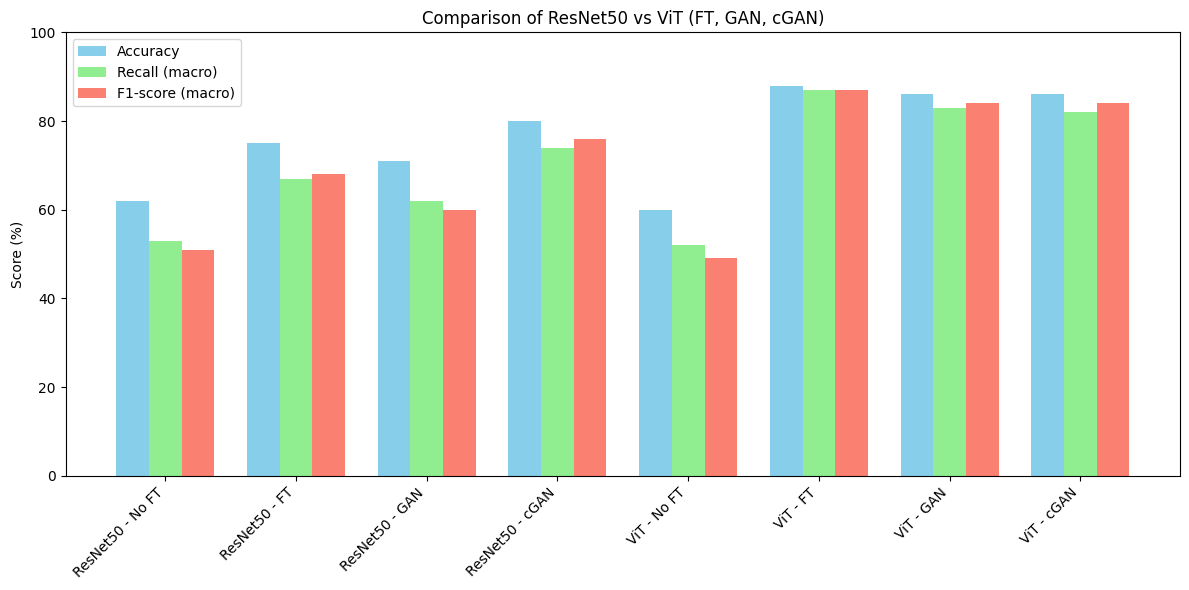

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Results from your evaluations ---
results = {
    "ResNet50 - No FT":     {"acc": 62, "recall": 53, "f1": 51},
    "ResNet50 - FT":        {"acc": 75, "recall": 67, "f1": 68},
    "ResNet50 - GAN":       {"acc": 71, "recall": 62, "f1": 60},
    "ResNet50 - cGAN":      {"acc": 80, "recall": 74, "f1": 76},
    "ViT - No FT":          {"acc": 60, "recall": 52, "f1": 49},
    "ViT - FT":             {"acc": 88, "recall": 87, "f1": 87},
    "ViT - GAN":            {"acc": 86, "recall": 83, "f1": 84},
    "ViT - cGAN":           {"acc": 86, "recall": 82, "f1": 84},
}

# --- Plot ---
labels = list(results.keys())
acc_values = [v["acc"] for v in results.values()]
recall_values = [v["recall"] for v in results.values()]
f1_values = [v["f1"] for v in results.values()]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, acc_values, width, label="Accuracy", color="skyblue")
plt.bar(x, recall_values, width, label="Recall (macro)", color="lightgreen")
plt.bar(x + width, f1_values, width, label="F1-score (macro)", color="salmon")

plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Score (%)")
plt.ylim(0, 100)
plt.title("Comparison of ResNet50 vs ViT (FT, GAN, cGAN)")
plt.legend()
plt.tight_layout()
plt.show()
